<a href="https://colab.research.google.com/github/Ragavi203/Predictive-Maintenance-using-MLOps-End-to-End-Production-ready-Pipeline/blob/main/Predictive_Maintenance_with_MLOps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Project structure created.
⬆️ Upload your predictive_maintenance.csv file


Saving PdM_errors.csv to PdM_errors.csv
Saving PdM_failures.csv to PdM_failures.csv
Saving PdM_machines.csv to PdM_machines.csv
Saving PdM_maint.csv to PdM_maint.csv
Saving PdM_telemetry.csv to PdM_telemetry.csv
✅ Moved PdM_errors.csv to raw data folder.
📈 Dataset shape: (3919, 3)


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4



🧹 Missing values:
datetime     0
machineID    0
errorID      0
dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


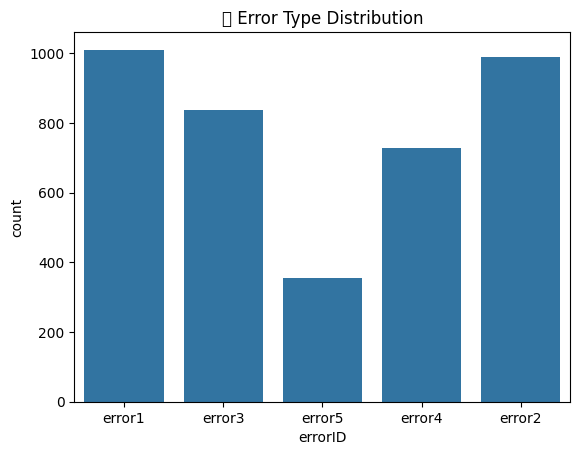

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


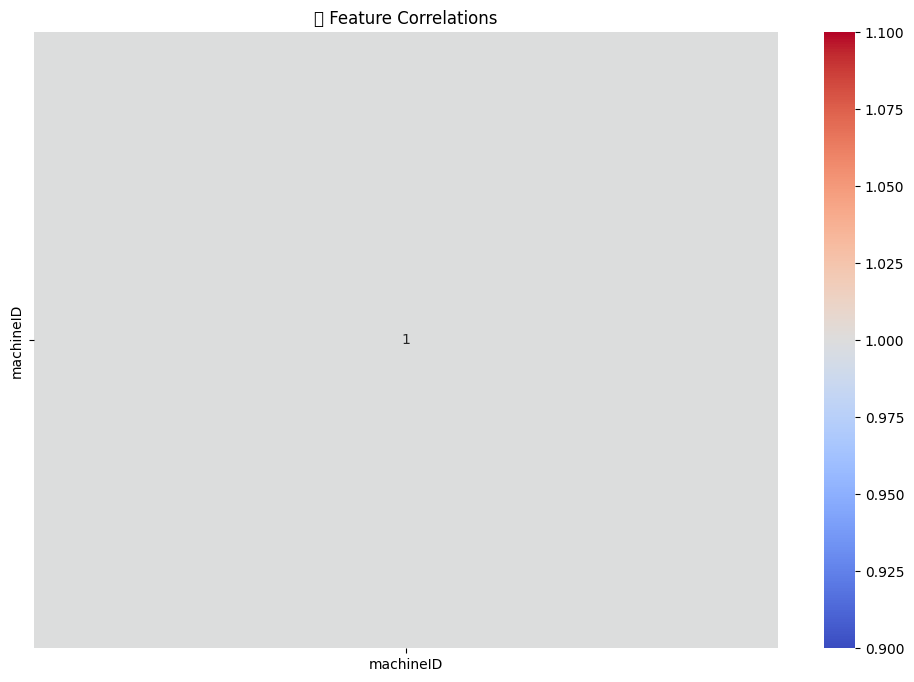


📌 Summary statistics:


,machineID
count,3919.000000
mean,51.044654
std,28.954988
min,1.000000
25%,25.000000
50%,51.000000
75%,77.000000
max,100.000000


In [ ]:
# 📍 SETUP
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Define base project directory
base_dir = '/content/predictive-maintenance-mlops'
dirs = [
    'data/raw', 'data/processed', 'notebooks', 'src',
    'config', 'deployment', 'monitoring', 'retraining', 'tests'
]

# Create project folders
for d in dirs:
    os.makedirs(os.path.join(base_dir, d), exist_ok=True)

print("✅ Project structure created.")

# 📂 UPLOAD DATASET
from google.colab import files
print("⬆️ Upload your predictive_maintenance.csv file")
uploaded = files.upload()

# Move uploaded file to raw data folder
filename = list(uploaded.keys())[0]
shutil.move(filename, f"{base_dir}/data/raw/{filename}")
print(f"✅ Moved {filename} to raw data folder.")

# 📊 EDA
# Load dataset
df = pd.read_csv(f"{base_dir}/data/raw/{filename}")
print("📈 Dataset shape:", df.shape)

# Peek at data
display(df.head())

# Check data types and missing values
print("\n🧹 Missing values:")
print(df.isnull().sum())

# Class distribution (updated for multi-class classification)
sns.countplot(x='errorID', data=df)
plt.title("🔧 Error Type Distribution")
plt.show()

# Select only numeric columns for correlation heatmap
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot the correlation heatmap for numeric features only
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', annot=True)
plt.title("📊 Feature Correlations")
plt.show()

# Describe numerical columns
print("\n📌 Summary statistics:")
display(df.describe())


In [ ]:
# Inspect unique values in 'errorID' to see what kind of information it holds
print(df['errorID'].unique())


['error1' 'error3' 'error5' 'error4' 'error2']


In [ ]:
# Convert 'datetime' to datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract useful time-based features
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Drop original datetime if not needed
df.drop('datetime', axis=1, inplace=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['errorID_encoded'] = le.fit_transform(df['errorID'])
df.drop('errorID', axis=1, inplace=True)  # Drop original errorID if encoded version used

# Just to check
print(df[['errorID_encoded']].value_counts())


errorID_encoded
0                  1010
1                   988
2                   838
3                   727
4                   356
Name: count, dtype: int64


In [ ]:
df = pd.get_dummies(df, columns=['machineID'], drop_first=True)


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('errorID_encoded', axis=1)
y = df['errorID_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Train shape: {X_train.shape}")
print(f"✅ Test shape: {X_test.shape}")


✅ Train shape: (3135, 102)
✅ Test shape: (784, 102)


In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(y.unique()),  # number of unique classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:29:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

      error1       0.26      0.35      0.30       189
      error2       0.20      0.25      0.23       204
      error3       0.19      0.13      0.16       181
      error4       0.24      0.20      0.22       136
      error5       0.21      0.09      0.13        74

    accuracy                           0.23       784
   macro avg       0.22      0.21      0.21       784
weighted avg       0.22      0.23      0.22       784



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


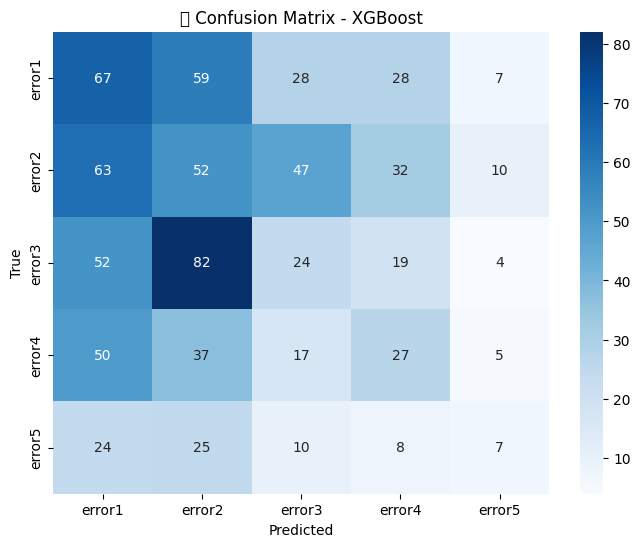

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🎯 Confusion Matrix - XGBoost")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


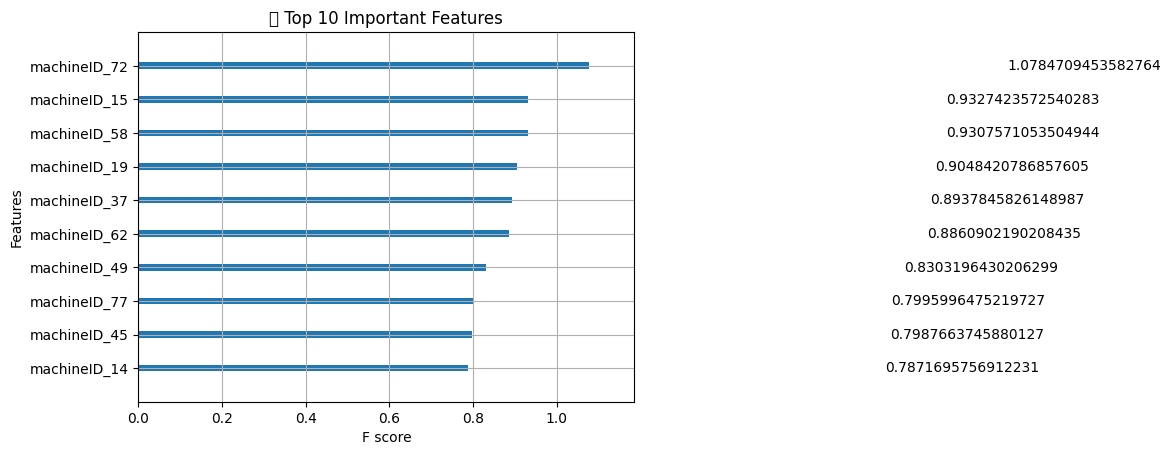

In [ ]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("🌟 Top 10 Important Features")
plt.show()


In [ ]:
!pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.xgboost

# Set tracking URI (local by default in Colab)
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Predictive Maintenance XGBoost")

with mlflow.start_run():
    # Enable autologging for XGBoost
    mlflow.xgboost.autolog()

    # Train model again inside the MLflow run
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    # Log predictions manually (optional)
    y_pred = xgb_model.predict(X_test)
    acc = (y_pred == y_test).mean()
    mlflow.log_metric("accuracy", acc)


2025/04/12 21:30:44 INFO mlflow.tracking.fluent: Experiment with name 'Predictive Maintenance XGBoost' does not exist. Creating a new experiment.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:30:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2025/04/12 21:30:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) wh

In [ ]:
!pip install pyngrok
from pyngrok import ngrok

# Start the MLflow UI server
get_ipython().system_raw("mlflow ui --port 5000 &")
ngrok.set_auth_token("YOUR NGROK AUTH TOEK")  # optional, for longer sessions
mlflow_url = ngrok.connect(5000)
print("🔗 MLflow UI:", mlflow_url)


🔗 MLflow UI: NgrokTunnel: "https://8070-34-32-177-35.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
import joblib
import os

model_path = os.path.join(base_dir, 'deployment', 'xgb_model.joblib')
joblib.dump(xgb_model, model_path)
print(f"✅ Model saved to {model_path}")


✅ Model saved to /content/predictive-maintenance-mlops/deployment/xgb_model.joblib


In [ ]:
import os
model_path = os.path.join(base_dir, 'deployment', 'xgb_model.joblib')
model = joblib.load(model_path)


In [ ]:
import joblib
import os

model_path = '/content/predictive-maintenance-mlops/deployment/xgb_model.joblib'
joblib.dump(xgb_model, model_path)

# Check if the file was actually created
print("✅ Saved:", os.path.exists(model_path), "| Path:", model_path)


✅ Saved: True | Path: /content/predictive-maintenance-mlops/deployment/xgb_model.joblib


In [ ]:
import joblib

model = joblib.load("/content/predictive-maintenance-mlops/deployment/xgb_model.joblib")


In [ ]:
!pip install fastapi uvicorn nest-asyncio pyngrok

import nest_asyncio
from pyngrok import ngrok
import uvicorn
import joblib
import os

# Apply async patch for Colab
nest_asyncio.apply()

# ✅ Make sure you're in the right working directory
os.chdir("/content/predictive-maintenance-mlops/deployment")

# ✅ Create FastAPI app file if not created yet
with open("app.py", "w") as f:
    f.write('''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

model = joblib.load("xgb_model.joblib")

class InputData(BaseModel):
    air_temperature: float
    process_temperature: float
    rotational_speed: float
    torque: float
    tool_wear: float
    hour: int
    dayofweek: int
    month: int
    machineID_2: int = 0

app = FastAPI()

@app.get("/")
def root():
    return {"message": "🛠️ Predictive Maintenance API is live!"}

@app.post("/predict/")
def predict(data: InputData):
    input_arr = np.array([[
        data.air_temperature,
        data.process_temperature,
        data.rotational_speed,
        data.torque,
        data.tool_wear,
        data.hour,
        data.dayofweek,
        data.month,
        data.machineID_2
    ]])

    pred_class = model.predict(input_arr)[0]
    return {"predicted_error_class": int(pred_class)}
''')

# ✅ Run the API
get_ipython().system_raw("uvicorn app:app --host 0.0.0.0 --port 8000 &")

# ✅ Expose API publicly
public_url = ngrok.connect(8000)
print("🌐 Your FastAPI endpoint:", public_url)


🌐 Your FastAPI endpoint: NgrokTunnel: "https://ebf3-34-32-177-35.ngrok-free.app" -> "http://localhost:8000"
